# Phase 6C: Selective Quantum-Inspired Integration

## Motivation

Notebook 06b (Fully Integrated) combined ALL quantum-inspired components and achieved:
- Better training loss (15% improvement)
- **But 200x WORSE test MSE**

This notebook takes a **selective approach** - integrating ONLY the components that showed positive results:

| Component | Individual Result | Include? |
|-----------|------------------|----------|
| Superposition Replay | ✅ 8% better prediction | **YES** |
| Error Correction Ensemble | ✅ Better MSE, robust | **YES** |
| QAOA Optimizer | ❌ 9x worse prediction | **NO** |
| Gate-Enhanced Layers | ❌ Mixed/unstable | **NO** |

## Why Some Approaches Failed

### QAOA Optimizer Failed Because:
1. **Wrong problem domain**: Designed for discrete combinatorial optimization, not continuous NN training
2. **Loss landscape mismatch**: Neural networks have smooth surfaces; QAOA expects discrete energy landscapes
3. **Operators don't translate**: Cost/mixer Hamiltonians don't map to gradient descent

### Gate-Enhanced Layers Failed Because:
1. **Quantum gates expect quantum states**: Hadamard/CNOT operate on normalized complex amplitudes
2. **Gradient flow disruption**: Entanglement operations create difficult optimization landscapes
3. **No quantum advantage**: Simulated on classical hardware, losing any potential benefit

### Superposition Replay Works Because:
1. **Proven analogue**: Similar to Prioritized Experience Replay (established technique)
2. **No architecture changes**: Only affects sampling, not model structure
3. **Amplitude weighting = prioritization**: Higher-reward episodes sampled more

### Error Correction Works Because:
1. **Ensemble methods are proven**: Model averaging reduces variance
2. **Redundancy principle is universal**: Works in classical and quantum domains
3. **Addresses real need**: World models benefit from robust predictions

## 6C.1 Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
from pathlib import Path
import json
import time
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Standard configuration per CLAUDE.md
CONFIG = {
    'obs_dim': 4,
    'action_dim': 2,  # One-hot encoded
    'stoch_dim': 64,
    'deter_dim': 512,
    'hidden_dim': 512,
    'batch_size': 32,
    'seq_len': 20,
    'num_epochs': 50,
    'learning_rate': 3e-4,
    'num_episodes': 100,
    'num_ensemble': 5,  # For error correction
}

# Standard seeds per CLAUDE.md
EXPERIMENT_SEEDS = [42, 123, 456, 789, 1024]

CONFIG['seeds'] = EXPERIMENT_SEEDS

print(f'Configuration: {CONFIG}')
print(f'Experiment seeds: {EXPERIMENT_SEEDS}')

Using device: cuda
Configuration: {'obs_dim': 4, 'action_dim': 2, 'stoch_dim': 64, 'deter_dim': 512, 'hidden_dim': 512, 'batch_size': 32, 'seq_len': 20, 'num_epochs': 50, 'learning_rate': 0.0003, 'num_episodes': 100, 'num_ensemble': 5, 'seeds': [42, 123, 456, 789, 1024]}
Experiment seeds: [42, 123, 456, 789, 1024]


## 6C.2 Classical World Model (Base Architecture)

Standard RSSM architecture WITHOUT quantum gate enhancements.

In [2]:
class ClassicalWorldModel(nn.Module):
    """
    Standard RSSM World Model without quantum enhancements.
    
    Architecture (per CLAUDE.md):
    - Encoder: [512, 512]
    - GRU: (stoch_dim + action_dim) -> deter_dim
    - Prior/Posterior: [512, 512] -> stoch_dim * 2
    - Decoder: [512, 512] -> obs_dim * 2
    - Reward: [512, 512] -> 1
    """
    
    def __init__(self, obs_dim: int, action_dim: int, config: Dict):
        super().__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.stoch_dim = config.get('stoch_dim', 64)
        self.deter_dim = config.get('deter_dim', 512)
        self.hidden_dim = config.get('hidden_dim', 512)
        self.state_dim = self.stoch_dim + self.deter_dim
        
        predictor_hidden = [512, 512]
        
        # Encoder: obs -> hidden
        self.encoder = nn.Sequential(
            nn.Linear(obs_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ELU(),
        )
        
        # GRU for temporal dynamics
        self.gru = nn.GRUCell(self.stoch_dim + action_dim, self.deter_dim)
        
        # Prior: deter -> stoch distribution
        prior_layers = []
        in_d = self.deter_dim
        for h in predictor_hidden:
            prior_layers.extend([nn.Linear(in_d, h), nn.ELU()])
            in_d = h
        prior_layers.append(nn.Linear(in_d, self.stoch_dim * 2))
        self.prior = nn.Sequential(*prior_layers)
        
        # Posterior: deter + embed -> stoch distribution
        posterior_layers = []
        in_d = self.deter_dim + self.hidden_dim
        for h in predictor_hidden:
            posterior_layers.extend([nn.Linear(in_d, h), nn.ELU()])
            in_d = h
        posterior_layers.append(nn.Linear(in_d, self.stoch_dim * 2))
        self.posterior = nn.Sequential(*posterior_layers)
        
        # Decoder: state -> obs distribution
        self.decoder = nn.Sequential(
            nn.Linear(self.state_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ELU(),
            nn.Linear(self.hidden_dim, obs_dim * 2)
        )
        
        # Reward predictor
        rew_layers = []
        in_d = self.state_dim
        for h in predictor_hidden:
            rew_layers.extend([nn.Linear(in_d, h), nn.ELU()])
            in_d = h
        rew_layers.append(nn.Linear(in_d, 1))
        self.reward_pred = nn.Sequential(*rew_layers)
    
    def initial_state(self, batch_size: int):
        return {
            'deter': torch.zeros(batch_size, self.deter_dim, device=DEVICE),
            'stoch': torch.zeros(batch_size, self.stoch_dim, device=DEVICE)
        }
    
    def get_dist(self, stats):
        mean, log_std = stats.chunk(2, dim=-1)
        std = F.softplus(log_std) + 0.1
        return torch.distributions.Normal(mean, std)
    
    def forward(self, obs_seq, action_seq):
        batch_size, seq_len = obs_seq.shape[:2]
        state = self.initial_state(batch_size)
        
        prior_means, prior_stds = [], []
        post_means, post_stds = [], []
        obs_means, obs_stds = [], []
        rewards = []
        states = []
        
        for t in range(seq_len):
            embed = self.encoder(obs_seq[:, t])
            
            # Prior
            prior_stats = self.prior(state['deter'])
            prior_dist = self.get_dist(prior_stats)
            
            # Posterior
            post_input = torch.cat([state['deter'], embed], dim=-1)
            post_stats = self.posterior(post_input)
            post_dist = self.get_dist(post_stats)
            
            # Sample stochastic state
            stoch = post_dist.rsample()
            
            # Update deterministic state
            gru_input = torch.cat([stoch, action_seq[:, t]], dim=-1)
            deter = self.gru(gru_input, state['deter'])
            
            # Full state
            full_state = torch.cat([deter, stoch], dim=-1)
            
            # Decode
            obs_stats = self.decoder(full_state)
            obs_mean, obs_log_std = obs_stats.chunk(2, dim=-1)
            obs_std = F.softplus(obs_log_std) + 0.1
            
            # Reward
            reward = self.reward_pred(full_state)
            
            # Store
            prior_means.append(prior_dist.mean)
            prior_stds.append(prior_dist.stddev)
            post_means.append(post_dist.mean)
            post_stds.append(post_dist.stddev)
            obs_means.append(obs_mean)
            obs_stds.append(obs_std)
            rewards.append(reward)
            states.append(full_state)
            
            state = {'deter': deter, 'stoch': stoch}
        
        return {
            'prior_mean': torch.stack(prior_means, dim=1),
            'prior_std': torch.stack(prior_stds, dim=1),
            'post_mean': torch.stack(post_means, dim=1),
            'post_std': torch.stack(post_stds, dim=1),
            'obs_mean': torch.stack(obs_means, dim=1),
            'obs_std': torch.stack(obs_stds, dim=1),
            'reward': torch.stack(rewards, dim=1).squeeze(-1),
            'states': torch.stack(states, dim=1)
        }

# Test
test_model = ClassicalWorldModel(CONFIG['obs_dim'], CONFIG['action_dim'], CONFIG).to(DEVICE)
print(f'ClassicalWorldModel parameters: {sum(p.numel() for p in test_model.parameters()):,}')

ClassicalWorldModel parameters: 3,720,969


## 6C.3 Superposition Replay Buffer (INCLUDED)

This component showed positive results - 8% better prediction error.
It's essentially prioritized experience replay with amplitude-based weighting.

In [3]:
@dataclass
class Episode:
    observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    total_reward: float


class SuperpositionReplayBuffer:
    """
    Replay buffer with quantum superposition-inspired sampling.
    
    Why it works:
    - Similar to Prioritized Experience Replay (proven technique)
    - Higher-reward episodes have higher 'amplitude' (sampling probability)
    - Interference between samples creates diverse batches
    - No model architecture changes, just smarter sampling
    """
    
    def __init__(self, capacity: int = 1000, parallel_samples: int = 4):
        self.capacity = capacity
        self.parallel_samples = parallel_samples
        self.episodes: List[Episode] = []
        self.amplitudes: np.ndarray = np.array([])
    
    def add_episode(self, episode: Episode):
        if len(self.episodes) >= self.capacity:
            self.episodes.pop(0)
        self.episodes.append(episode)
        self._update_amplitudes()
    
    def _update_amplitudes(self):
        """Update amplitude weights based on episode rewards."""
        if not self.episodes:
            self.amplitudes = np.array([])
            return
        
        rewards = np.array([ep.total_reward for ep in self.episodes])
        # Shift to positive and normalize
        shifted = rewards - rewards.min() + 1.0
        # Square root for amplitude (like quantum probability)
        amplitudes = np.sqrt(shifted)
        # Normalize to probabilities
        self.amplitudes = amplitudes / amplitudes.sum()
    
    def __len__(self):
        return len(self.episodes)
    
    def sample_superposition(self, batch_size: int, seq_len: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Sample using superposition-inspired parallel sampling with interference."""
        if len(self.episodes) < self.parallel_samples:
            return self.sample_standard(batch_size, seq_len)
        
        obs_batch, action_batch, reward_batch = [], [], []
        
        for _ in range(batch_size):
            # Sample parallel_samples episodes based on amplitudes
            indices = np.random.choice(
                len(self.episodes), 
                size=self.parallel_samples, 
                p=self.amplitudes,
                replace=False if len(self.episodes) >= self.parallel_samples else True
            )
            
            # Get episodes and their amplitudes
            sampled_eps = [self.episodes[i] for i in indices]
            sampled_amps = self.amplitudes[indices]
            sampled_amps = sampled_amps / sampled_amps.sum()  # Renormalize
            
            # Interference: weighted combination
            valid_eps = [ep for ep in sampled_eps if len(ep.observations) >= seq_len]
            if not valid_eps:
                # Fallback to standard sampling
                ep = np.random.choice([e for e in self.episodes if len(e.observations) >= seq_len])
                start = np.random.randint(0, len(ep.observations) - seq_len + 1)
                obs_batch.append(ep.observations[start:start+seq_len])
                action_batch.append(ep.actions[start:start+seq_len])
                reward_batch.append(ep.rewards[start:start+seq_len])
            else:
                # Choose based on interference pattern
                chosen_idx = np.random.choice(len(valid_eps), p=sampled_amps[:len(valid_eps)]/sampled_amps[:len(valid_eps)].sum())
                ep = valid_eps[chosen_idx]
                start = np.random.randint(0, len(ep.observations) - seq_len + 1)
                obs_batch.append(ep.observations[start:start+seq_len])
                action_batch.append(ep.actions[start:start+seq_len])
                reward_batch.append(ep.rewards[start:start+seq_len])
        
        return (
            torch.FloatTensor(np.array(obs_batch)).to(DEVICE),
            torch.FloatTensor(np.array(action_batch)).to(DEVICE),
            torch.FloatTensor(np.array(reward_batch)).to(DEVICE)
        )
    
    def sample_standard(self, batch_size: int, seq_len: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Standard uniform sampling (baseline)."""
        obs_batch, action_batch, reward_batch = [], [], []
        
        valid_episodes = [ep for ep in self.episodes if len(ep.observations) >= seq_len]
        
        for _ in range(batch_size):
            episode = np.random.choice(valid_episodes)
            start = np.random.randint(0, len(episode.observations) - seq_len + 1)
            obs_batch.append(episode.observations[start:start+seq_len])
            action_batch.append(episode.actions[start:start+seq_len])
            reward_batch.append(episode.rewards[start:start+seq_len])
        
        return (
            torch.FloatTensor(np.array(obs_batch)).to(DEVICE),
            torch.FloatTensor(np.array(action_batch)).to(DEVICE),
            torch.FloatTensor(np.array(reward_batch)).to(DEVICE)
        )

print('SuperpositionReplayBuffer defined.')

SuperpositionReplayBuffer defined.


## 6C.4 Error Correction Ensemble (INCLUDED)

This component showed positive results - better MSE and robustness.
It's an ensemble of models with majority voting / averaging.

In [4]:
class ErrorCorrectionEnsemble(nn.Module):
    """
    Ensemble of world models with error correction.
    
    Why it works:
    - Ensemble averaging is a proven ML technique
    - Reduces variance in predictions
    - Redundancy provides robustness (like quantum error correction)
    - Simple and mathematically sound
    """
    
    def __init__(self, obs_dim: int, action_dim: int, config: Dict, num_models: int = 5):
        super().__init__()
        self.num_models = num_models
        self.models = nn.ModuleList([
            ClassicalWorldModel(obs_dim, action_dim, config)
            for _ in range(num_models)
        ])
        self.correction_method = 'average'  # Can be 'average', 'median', 'weighted'
    
    def forward(self, obs_seq, action_seq):
        """Forward pass through all models with error correction."""
        all_outputs = [model(obs_seq, action_seq) for model in self.models]
        
        # Stack predictions from all models
        obs_preds = torch.stack([out['obs_mean'] for out in all_outputs], dim=0)
        reward_preds = torch.stack([out['reward'] for out in all_outputs], dim=0)
        
        # Apply error correction
        if self.correction_method == 'median':
            corrected_obs = obs_preds.median(dim=0).values
            corrected_reward = reward_preds.median(dim=0).values
        elif self.correction_method == 'weighted':
            # Weight by inverse disagreement
            disagreement = obs_preds.std(dim=0, keepdim=True)
            weights = 1.0 / (disagreement + 1e-6)
            weights = weights / weights.sum(dim=0, keepdim=True)
            corrected_obs = (obs_preds * weights).sum(dim=0)
            corrected_reward = (reward_preds * weights.mean(dim=-1, keepdim=True)).sum(dim=0)
        else:  # 'average'
            corrected_obs = obs_preds.mean(dim=0)
            corrected_reward = reward_preds.mean(dim=0)
        
        # Calculate uncertainty (disagreement between models)
        uncertainty = obs_preds.std(dim=0).mean()
        
        return {
            'obs_mean': corrected_obs,
            'reward': corrected_reward,
            'uncertainty': uncertainty,
            'prior_mean': all_outputs[0]['prior_mean'],
            'prior_std': all_outputs[0]['prior_std'],
            'post_mean': all_outputs[0]['post_mean'],
            'post_std': all_outputs[0]['post_std'],
            'obs_std': all_outputs[0]['obs_std'],
            'states': all_outputs[0]['states'],
        }

# Test
ensemble = ErrorCorrectionEnsemble(CONFIG['obs_dim'], CONFIG['action_dim'], CONFIG, num_models=5).to(DEVICE)
print(f'ErrorCorrectionEnsemble total parameters: {sum(p.numel() for p in ensemble.parameters()):,}')
print(f'Parameters per model: {sum(p.numel() for p in ensemble.models[0].parameters()):,}')

ErrorCorrectionEnsemble total parameters: 18,604,845
Parameters per model: 3,720,969


## 6C.5 Selective Integration Trainer

Combines:
- ✅ Superposition Replay Buffer (for sampling)
- ✅ Error Correction Ensemble (for predictions)
- ✅ Standard Adam Optimizer (NOT QAOA)
- ✅ Classical Layers (NOT Gate-Enhanced)

In [5]:
class SelectiveIntegrationTrainer:
    """
    Trainer that selectively integrates only beneficial quantum-inspired components:
    - Superposition Replay: YES (proven to help)
    - Error Correction Ensemble: YES (proven to help)
    - QAOA Optimizer: NO (9x worse results)
    - Gate-Enhanced Layers: NO (unstable results)
    """
    
    def __init__(self, ensemble: ErrorCorrectionEnsemble, buffer: SuperpositionReplayBuffer, config: Dict):
        self.ensemble = ensemble
        self.buffer = buffer
        self.config = config
        
        # Standard Adam optimizer (NOT QAOA)
        self.optimizer = torch.optim.AdamW(
            ensemble.parameters(),
            lr=config.get('learning_rate', 3e-4)
        )
    
    def compute_loss(self, obs_seq, action_seq, reward_seq):
        """Compute world model loss."""
        outputs = self.ensemble(obs_seq, action_seq)
        
        # Reconstruction loss
        recon_loss = F.mse_loss(outputs['obs_mean'], obs_seq)
        
        # KL divergence
        prior_dist = torch.distributions.Normal(outputs['prior_mean'], outputs['prior_std'])
        post_dist = torch.distributions.Normal(outputs['post_mean'], outputs['post_std'])
        kl_loss = torch.clamp(
            torch.distributions.kl_divergence(post_dist, prior_dist).mean(),
            min=1.0
        )
        
        # Reward loss
        reward_loss = F.mse_loss(outputs['reward'], reward_seq)
        
        # Total loss
        total_loss = recon_loss + 0.1 * kl_loss + reward_loss
        
        return total_loss, {
            'recon_loss': recon_loss.item(),
            'kl_loss': kl_loss.item(),
            'reward_loss': reward_loss.item(),
            'uncertainty': outputs['uncertainty'].item()
        }
    
    def train(self, num_epochs: int, use_superposition: bool = True):
        """Train using selective integration."""
        history = {'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'reward_loss': [], 'uncertainty': []}
        
        for epoch in range(num_epochs):
            self.ensemble.train()
            
            # Sample using superposition (beneficial) or standard (baseline)
            if use_superposition:
                obs_seq, action_seq, reward_seq = self.buffer.sample_superposition(
                    self.config['batch_size'], self.config['seq_len']
                )
            else:
                obs_seq, action_seq, reward_seq = self.buffer.sample_standard(
                    self.config['batch_size'], self.config['seq_len']
                )
            
            # Standard training step (NOT QAOA)
            self.optimizer.zero_grad()
            loss, metrics = self.compute_loss(obs_seq, action_seq, reward_seq)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.ensemble.parameters(), 100.0)
            self.optimizer.step()
            
            # Record history
            history['total_loss'].append(loss.item())
            for key, value in metrics.items():
                if key in history:
                    history[key].append(value)
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}: Loss = {loss.item():.4f}, Uncertainty = {metrics["uncertainty"]:.4f}')
        
        return history
    
    def evaluate(self, test_obs, test_actions):
        """Evaluate ensemble on test data."""
        self.ensemble.eval()
        with torch.no_grad():
            outputs = self.ensemble(test_obs, test_actions)
            mse = F.mse_loss(outputs['obs_mean'], test_obs).item()
        return {
            'ensemble_mse': mse,
            'mean_uncertainty': outputs['uncertainty'].item()
        }

print('SelectiveIntegrationTrainer defined.')

SelectiveIntegrationTrainer defined.


## 6C.6 Long-Horizon Prediction Test

In [6]:
# Standard horizons per CLAUDE.md
LONG_HORIZON_HORIZONS = [5, 10, 15, 20]

def evaluate_long_horizon(model, obs_seq: torch.Tensor, action_seq: torch.Tensor, 
                          horizons: List[int] = None) -> Dict:
    """
    Evaluate prediction accuracy at different horizons.
    """
    if horizons is None:
        horizons = LONG_HORIZON_HORIZONS
    
    model.eval()
    results = {}
    
    with torch.no_grad():
        outputs = model(obs_seq, action_seq)
        pred_obs = outputs['obs_mean']
        
        for h in horizons:
            if h <= obs_seq.shape[1]:
                mse_at_h = F.mse_loss(pred_obs[:, h-1:h], obs_seq[:, h-1:h]).item()
                results[f'mse_horizon_{h}'] = mse_at_h
        
        results['avg_horizon_mse'] = np.mean([v for k, v in results.items() if 'mse_horizon' in k])
        
        if len(horizons) >= 2:
            first_h = horizons[0]
            last_h = min(horizons[-1], obs_seq.shape[1])
            if f'mse_horizon_{first_h}' in results and f'mse_horizon_{last_h}' in results:
                error_growth = results[f'mse_horizon_{last_h}'] / (results[f'mse_horizon_{first_h}'] + 1e-8)
                results['error_growth_rate'] = error_growth
    
    return results

print(f'Long-horizon evaluation function defined.')
print(f'Horizons: {LONG_HORIZON_HORIZONS}')

Long-horizon evaluation function defined.
Horizons: [5, 10, 15, 20]


## 6C.7 Data Collection

In [7]:
def collect_episodes(env_name: str, num_episodes: int, seed: int = None) -> List[Episode]:
    """Collect episodes from environment."""
    env = gym.make(env_name)
    if seed is not None:
        np.random.seed(seed)
    
    episodes = []
    
    for _ in range(num_episodes):
        obs, _ = env.reset(seed=seed + _ if seed else None)
        observations = [obs]
        actions = []
        rewards = []
        done = False
        
        while not done:
            action = env.action_space.sample()
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # One-hot encode action
            action_onehot = np.zeros(env.action_space.n, dtype=np.float32)
            action_onehot[action] = 1.0
            actions.append(action_onehot)
            
            rewards.append(reward)
            observations.append(next_obs)
        
        episodes.append(Episode(
            observations=np.array(observations[:-1], dtype=np.float32),
            actions=np.array(actions, dtype=np.float32),
            rewards=np.array(rewards, dtype=np.float32),
            total_reward=sum(rewards)
        ))
    
    env.close()
    avg_reward = np.mean([ep.total_reward for ep in episodes])
    avg_length = np.mean([len(ep.observations) for ep in episodes])
    print(f'Collected {num_episodes} episodes, avg reward: {avg_reward:.1f}, avg length: {avg_length:.1f}')
    return episodes

# Collect training data
print('Collecting training data...')
training_episodes = collect_episodes('CartPole-v1', CONFIG['num_episodes'], seed=42)

Collected 100 episodes, avg reward: 23.1, avg length: 23.1


## 6C.8 Run Experiment Function

In [8]:
def run_experiment(seed: int, config: Dict) -> Dict:
    """Run single experiment with given seed."""
    print(f'\n{"="*60}')
    print(f'Running experiment with seed {seed}')
    print(f'{"="*60}')
    
    # Set seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Collect data
    episodes = collect_episodes('CartPole-v1', config['num_episodes'], seed=seed)
    
    # Prepare buffer with superposition sampling
    buffer = SuperpositionReplayBuffer(capacity=1000, parallel_samples=4)
    for ep in episodes:
        buffer.add_episode(ep)
    
    # Prepare test data
    seq_len = config['seq_len']
    valid_episodes = [ep for ep in episodes if len(ep.observations) >= seq_len]
    test_episodes = valid_episodes[-10:] if len(valid_episodes) >= 10 else valid_episodes
    
    test_obs = torch.FloatTensor(np.stack([ep.observations[:seq_len] for ep in test_episodes])).to(DEVICE)
    test_actions = torch.FloatTensor(np.stack([ep.actions[:seq_len] for ep in test_episodes])).to(DEVICE)
    test_rewards = torch.FloatTensor(np.stack([ep.rewards[:seq_len] for ep in test_episodes])).to(DEVICE)
    
    results = {}
    
    # ============================================================
    # Train Classical Baseline (for comparison)
    # ============================================================
    print('\nTraining Classical Baseline...')
    classical_model = ClassicalWorldModel(config['obs_dim'], config['action_dim'], config).to(DEVICE)
    classical_optimizer = torch.optim.AdamW(classical_model.parameters(), lr=config['learning_rate'])
    
    classical_start = time.time()
    classical_losses = []
    
    for epoch in range(config['num_epochs']):
        classical_model.train()
        obs, act, rew = buffer.sample_standard(config['batch_size'], config['seq_len'])
        
        classical_optimizer.zero_grad()
        outputs = classical_model(obs, act)
        
        recon_loss = F.mse_loss(outputs['obs_mean'], obs)
        prior_dist = torch.distributions.Normal(outputs['prior_mean'], outputs['prior_std'])
        post_dist = torch.distributions.Normal(outputs['post_mean'], outputs['post_std'])
        kl_loss = torch.clamp(torch.distributions.kl_divergence(post_dist, prior_dist).mean(), min=1.0)
        reward_loss = F.mse_loss(outputs['reward'], rew)
        loss = recon_loss + 0.1 * kl_loss + reward_loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classical_model.parameters(), 100.0)
        classical_optimizer.step()
        classical_losses.append(loss.item())
    
    classical_time = time.time() - classical_start
    
    # Evaluate classical
    classical_model.eval()
    with torch.no_grad():
        classical_outputs = classical_model(test_obs, test_actions)
        classical_mse = F.mse_loss(classical_outputs['obs_mean'], test_obs).item()
    
    classical_horizon = evaluate_long_horizon(classical_model, test_obs, test_actions)
    
    results['classical'] = {
        'final_loss': classical_losses[-1],
        'test_mse': classical_mse,
        'training_time': classical_time,
        'long_horizon': classical_horizon,
        'params': sum(p.numel() for p in classical_model.parameters()),
        'history': classical_losses,
    }
    
    print(f'  Classical - Loss: {classical_losses[-1]:.4f}, MSE: {classical_mse:.6f}')
    
    # ============================================================
    # Train Selective Integration (Superposition + Error Correction)
    # ============================================================
    print('\nTraining Selective Integration (Superposition + Error Correction)...')
    
    # Re-seed for fair comparison
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    selective_ensemble = ErrorCorrectionEnsemble(
        config['obs_dim'], config['action_dim'], config, num_models=config['num_ensemble']
    ).to(DEVICE)
    
    selective_trainer = SelectiveIntegrationTrainer(selective_ensemble, buffer, config)
    
    selective_start = time.time()
    selective_history = selective_trainer.train(config['num_epochs'], use_superposition=True)
    selective_time = time.time() - selective_start
    
    # Evaluate selective
    selective_eval = selective_trainer.evaluate(test_obs, test_actions)
    selective_horizon = evaluate_long_horizon(selective_ensemble, test_obs, test_actions)
    
    results['selective'] = {
        'final_loss': selective_history['total_loss'][-1],
        'test_mse': selective_eval['ensemble_mse'],
        'training_time': selective_time,
        'long_horizon': selective_horizon,
        'uncertainty': selective_eval['mean_uncertainty'],
        'params': sum(p.numel() for p in selective_ensemble.parameters()),
        'history': selective_history['total_loss'],
    }
    
    print(f'  Selective - Loss: {selective_history["total_loss"][-1]:.4f}, MSE: {selective_eval["ensemble_mse"]:.6f}')
    
    return results

print('run_experiment function defined.')

run_experiment function defined.


## 6C.9 Multi-Seed Experiments

In [9]:
# Run experiments with all 5 seeds
all_results = []
for seed in CONFIG['seeds']:
    result = run_experiment(seed, CONFIG)
    all_results.append(result)


Running experiment with seed 42
Collected 100 episodes, avg reward: 22.0, avg length: 22.0

Training Classical Baseline...
  Classical - Loss: 0.1205, MSE: 0.006137

Training Selective Integration (Superposition + Error Correction)...
Epoch 10/50: Loss = 0.2220, Uncertainty = 0.1096
Epoch 20/50: Loss = 0.1511, Uncertainty = 0.1451
Epoch 30/50: Loss = 0.1223, Uncertainty = 0.1361
Epoch 40/50: Loss = 0.1188, Uncertainty = 0.1068
Epoch 50/50: Loss = 0.1178, Uncertainty = 0.1199
  Selective - Loss: 0.1178, MSE: 0.005793

Running experiment with seed 123
Collected 100 episodes, avg reward: 22.6, avg length: 22.6

Training Classical Baseline...
  Classical - Loss: 0.1136, MSE: 0.009156

Training Selective Integration (Superposition + Error Correction)...
Epoch 10/50: Loss = 0.2326, Uncertainty = 0.1308
Epoch 20/50: Loss = 0.1467, Uncertainty = 0.1729
Epoch 30/50: Loss = 0.1309, Uncertainty = 0.1853
Epoch 40/50: Loss = 0.1195, Uncertainty = 0.1503
Epoch 50/50: Loss = 0.1137, Uncertainty = 0.

## 6C.10 Test Set Evaluation

In [10]:
print('='*70)
print('TEST SET EVALUATION')
print('='*70)

# Collect held-out test data with different seed
print('\nCollecting held-out test data with seed 9999...')
test_episodes = collect_episodes('CartPole-v1', 50, seed=9999)

# Prepare test batch
seq_len = CONFIG['seq_len']
valid_test = [ep for ep in test_episodes if len(ep.observations) >= seq_len]
test_batch = valid_test[:20]

test_obs = torch.FloatTensor(np.stack([ep.observations[:seq_len] for ep in test_batch])).to(DEVICE)
test_actions = torch.FloatTensor(np.stack([ep.actions[:seq_len] for ep in test_batch])).to(DEVICE)

print(f'Test set: {len(test_batch)} episodes, shape: {test_obs.shape}')

# Evaluate trained models
test_results = {'classical': [], 'selective': []}

print('\nTraining fresh models for test set evaluation...')
for seed in EXPERIMENT_SEEDS[:3]:  # Use first 3 seeds for efficiency
    print(f'\n  Seed {seed}:')
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Collect fresh training data
    train_episodes = collect_episodes('CartPole-v1', CONFIG['num_episodes'], seed=seed)
    buffer = SuperpositionReplayBuffer(capacity=1000, parallel_samples=4)
    for ep in train_episodes:
        buffer.add_episode(ep)
    
    # Train and evaluate Classical
    classical_model = ClassicalWorldModel(CONFIG['obs_dim'], CONFIG['action_dim'], CONFIG).to(DEVICE)
    classical_opt = torch.optim.AdamW(classical_model.parameters(), lr=CONFIG['learning_rate'])
    
    for _ in range(CONFIG['num_epochs']):
        classical_model.train()
        obs, act, rew = buffer.sample_standard(CONFIG['batch_size'], CONFIG['seq_len'])
        classical_opt.zero_grad()
        outputs = classical_model(obs, act)
        recon = F.mse_loss(outputs['obs_mean'], obs)
        prior_d = torch.distributions.Normal(outputs['prior_mean'], outputs['prior_std'])
        post_d = torch.distributions.Normal(outputs['post_mean'], outputs['post_std'])
        kl = torch.clamp(torch.distributions.kl_divergence(post_d, prior_d).mean(), min=1.0)
        rew_loss = F.mse_loss(outputs['reward'], rew)
        loss = recon + 0.1 * kl + rew_loss
        loss.backward()
        classical_opt.step()
    
    classical_model.eval()
    with torch.no_grad():
        classical_out = classical_model(test_obs, test_actions)
        classical_test_mse = F.mse_loss(classical_out['obs_mean'], test_obs).item()
    test_results['classical'].append(classical_test_mse)
    print(f'    Classical test MSE: {classical_test_mse:.6f}')
    
    # Train and evaluate Selective
    torch.manual_seed(seed)
    selective_ensemble = ErrorCorrectionEnsemble(CONFIG['obs_dim'], CONFIG['action_dim'], CONFIG, num_models=CONFIG['num_ensemble']).to(DEVICE)
    selective_trainer = SelectiveIntegrationTrainer(selective_ensemble, buffer, CONFIG)
    selective_trainer.train(CONFIG['num_epochs'], use_superposition=True)
    
    selective_eval = selective_trainer.evaluate(test_obs, test_actions)
    test_results['selective'].append(selective_eval['ensemble_mse'])
    print(f'    Selective test MSE: {selective_eval["ensemble_mse"]:.6f}')

print('\n' + '='*70)
print('TEST SET RESULTS')
print('='*70)
print(f'\nClassical Test MSE:  {np.mean(test_results["classical"]):.6f} +/- {np.std(test_results["classical"]):.6f}')
print(f'Selective Test MSE:  {np.mean(test_results["selective"]):.6f} +/- {np.std(test_results["selective"]):.6f}')

TEST SET EVALUATION

Collected 50 episodes, avg reward: 21.3, avg length: 21.3
Test set: 20 episodes, shape: torch.Size([20, 20, 4])

Training fresh models for test set evaluation...

  Seed 42:
Collected 100 episodes, avg reward: 22.1, avg length: 22.1
    Classical test MSE: 0.007338
Epoch 10/50: Loss = 0.2273, Uncertainty = 0.1180
Epoch 20/50: Loss = 0.1517, Uncertainty = 0.1461
Epoch 30/50: Loss = 0.1228, Uncertainty = 0.1458
Epoch 40/50: Loss = 0.1181, Uncertainty = 0.1183
Epoch 50/50: Loss = 0.1140, Uncertainty = 0.1301
    Selective test MSE: 0.007122

  Seed 123:
Collected 100 episodes, avg reward: 20.3, avg length: 20.3
    Classical test MSE: 0.008646
Epoch 10/50: Loss = 0.2414, Uncertainty = 0.0942
Epoch 20/50: Loss = 0.1429, Uncertainty = 0.1890
Epoch 30/50: Loss = 0.1204, Uncertainty = 0.1335
Epoch 40/50: Loss = 0.1201, Uncertainty = 0.1138
Epoch 50/50: Loss = 0.1137, Uncertainty = 0.1270
    Selective test MSE: 0.006640

  Seed 456:
Collected 100 episodes, avg reward: 22.

## 6C.11 Statistical Analysis

In [11]:
print('='*70)
print('STATISTICAL ANALYSIS')
print('='*70)

# Extract metrics
classical_losses = [r['classical']['final_loss'] for r in all_results]
selective_losses = [r['selective']['final_loss'] for r in all_results]
classical_mses = [r['classical']['test_mse'] for r in all_results]
selective_mses = [r['selective']['test_mse'] for r in all_results]
classical_times = [r['classical']['training_time'] for r in all_results]
selective_times = [r['selective']['training_time'] for r in all_results]

# Long-horizon metrics
classical_horizon_growth = [r['classical']['long_horizon'].get('error_growth_rate', 1.0) for r in all_results]
selective_horizon_growth = [r['selective']['long_horizon'].get('error_growth_rate', 1.0) for r in all_results]

print('\n' + '-'*70)
print('1. FINAL LOSS COMPARISON')
print('-'*70)
print(f'Classical:  {np.mean(classical_losses):.4f} +/- {np.std(classical_losses):.4f}')
print(f'Selective:  {np.mean(selective_losses):.4f} +/- {np.std(selective_losses):.4f}')

stat, p_loss = stats.mannwhitneyu(classical_losses, selective_losses, alternative='two-sided')
print(f'Mann-Whitney U: p={p_loss:.6f}')

pooled_std = np.sqrt((np.std(classical_losses)**2 + np.std(selective_losses)**2) / 2)
cohens_d_loss = (np.mean(classical_losses) - np.mean(selective_losses)) / (pooled_std + 1e-8)
print(f"Cohen's d: {cohens_d_loss:.4f}")

print('\n' + '-'*70)
print('2. TEST MSE COMPARISON')
print('-'*70)
print(f'Classical:  {np.mean(classical_mses):.6f} +/- {np.std(classical_mses):.6f}')
print(f'Selective:  {np.mean(selective_mses):.6f} +/- {np.std(selective_mses):.6f}')

stat, p_mse = stats.mannwhitneyu(classical_mses, selective_mses, alternative='two-sided')
print(f'Mann-Whitney U: p={p_mse:.6f}')

improvement = (np.mean(classical_mses) - np.mean(selective_mses)) / np.mean(classical_mses) * 100
print(f'Improvement: {improvement:.1f}%')

pooled_std_mse = np.sqrt((np.std(classical_mses)**2 + np.std(selective_mses)**2) / 2)
cohens_d_mse = (np.mean(classical_mses) - np.mean(selective_mses)) / (pooled_std_mse + 1e-8)
print(f"Cohen's d: {cohens_d_mse:.4f}")

print('\n' + '-'*70)
print('3. LONG-HORIZON ERROR GROWTH')
print('-'*70)
print(f'Classical error growth:  {np.mean(classical_horizon_growth):.4f} +/- {np.std(classical_horizon_growth):.4f}')
print(f'Selective error growth:  {np.mean(selective_horizon_growth):.4f} +/- {np.std(selective_horizon_growth):.4f}')
print('(Lower is better)')

print('\n' + '-'*70)
print('4. TRAINING TIME')
print('-'*70)
print(f'Classical:  {np.mean(classical_times):.2f}s +/- {np.std(classical_times):.2f}s')
print(f'Selective:  {np.mean(selective_times):.2f}s +/- {np.std(selective_times):.2f}s')

print('\n' + '-'*70)
print('5. COMPUTATIONAL COST')
print('-'*70)
print(f'Classical params:  {all_results[0]["classical"]["params"]:,}')
print(f'Selective params:  {all_results[0]["selective"]["params"]:,}')
print(f'Ratio: {all_results[0]["selective"]["params"] / all_results[0]["classical"]["params"]:.1f}x')

print('\n' + '-'*70)
print('6. BONFERRONI-CORRECTED SIGNIFICANCE')
print('-'*70)
bonferroni_alpha = 0.025
print(f'Bonferroni-corrected alpha: {bonferroni_alpha}')
print(f'Loss comparison: p={p_loss:.6f} - {"SIGNIFICANT" if p_loss < bonferroni_alpha else "not significant"}')
print(f'MSE comparison:  p={p_mse:.6f} - {"SIGNIFICANT" if p_mse < bonferroni_alpha else "not significant"}')

STATISTICAL ANALYSIS

----------------------------------------------------------------------
1. FINAL LOSS COMPARISON
----------------------------------------------------------------------
Classical:  0.1166 +/- 0.0035
Selective:  0.1165 +/- 0.0023
Mann-Whitney U: p=1.000000
Cohen's d: 0.0272

----------------------------------------------------------------------
2. TEST MSE COMPARISON
----------------------------------------------------------------------
Classical:  0.007613 +/- 0.001200
Selective:  0.007767 +/- 0.001670
Mann-Whitney U: p=1.000000
Improvement: -2.0%
Cohen's d: -0.1062

----------------------------------------------------------------------
3. LONG-HORIZON ERROR GROWTH
----------------------------------------------------------------------
Classical error growth:  7.0819 +/- 1.4647
Selective error growth:  9.8437 +/- 4.1877
(Lower is better)

----------------------------------------------------------------------
4. TRAINING TIME
------------------------------------------

## 6C.12 Save Results

In [12]:
import pandas as pd

results_dir = Path('../experiments/results/selective_integration')
results_dir.mkdir(parents=True, exist_ok=True)

# Helper function for JSON serialization
def to_python_type(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.bool_,)):
        return bool(obj)
    elif isinstance(obj, list):
        return [to_python_type(x) for x in obj]
    elif isinstance(obj, dict):
        return {k: to_python_type(v) for k, v in obj.items()}
    return obj

# Prepare results
save_results = {
    'metadata': {
        'phase': '6c',
        'experiment': 'Selective Quantum-Inspired Integration',
        'components_included': ['Superposition Replay', 'Error Correction Ensemble'],
        'components_excluded': ['QAOA Optimizer', 'Gate-Enhanced Layers'],
        'environment': 'CartPole-v1',
        'num_seeds': len(CONFIG['seeds']),
        'seeds': CONFIG['seeds'],
        'num_epochs': CONFIG['num_epochs'],
        'batch_size': CONFIG['batch_size'],
        'seq_len': CONFIG['seq_len'],
        'learning_rate': CONFIG['learning_rate'],
        'stoch_dim': CONFIG['stoch_dim'],
        'deter_dim': CONFIG['deter_dim'],
        'hidden_dim': CONFIG['hidden_dim'],
        'num_ensemble': CONFIG['num_ensemble'],
        'bonferroni_alpha': 0.025,
    },
    'final_performance': {
        'classical_loss_mean': float(np.mean(classical_losses)),
        'classical_loss_std': float(np.std(classical_losses)),
        'selective_loss_mean': float(np.mean(selective_losses)),
        'selective_loss_std': float(np.std(selective_losses)),
    },
    'prediction_accuracy': {
        'classical_test_mse_mean': float(np.mean(classical_mses)),
        'classical_test_mse_std': float(np.std(classical_mses)),
        'selective_test_mse_mean': float(np.mean(selective_mses)),
        'selective_test_mse_std': float(np.std(selective_mses)),
    },
    'training_speed': {
        'classical_mean_time': float(np.mean(classical_times)),
        'selective_mean_time': float(np.mean(selective_times)),
    },
    'computational_cost': {
        'classical_params': int(all_results[0]['classical']['params']),
        'selective_params': int(all_results[0]['selective']['params']),
    },
    'statistical_tests': {
        'loss_comparison': {
            'p_value': float(p_loss),
            'cohens_d': float(cohens_d_loss),
            'significant_bonferroni': bool(p_loss < 0.025),
            'winner': 'Selective' if np.mean(selective_losses) < np.mean(classical_losses) else 'Classical',
        },
        'mse_comparison': {
            'p_value': float(p_mse),
            'cohens_d': float(cohens_d_mse),
            'improvement_percent': float(improvement),
            'significant_bonferroni': bool(p_mse < 0.025),
            'winner': 'Selective' if np.mean(selective_mses) < np.mean(classical_mses) else 'Classical',
        },
    },
    'long_horizon': {
        'classical_error_growth': [float(x) for x in classical_horizon_growth],
        'selective_error_growth': [float(x) for x in selective_horizon_growth],
    },
    'raw_results': {
        'classical_final_losses': [float(x) for x in classical_losses],
        'selective_final_losses': [float(x) for x in selective_losses],
        'classical_test_mses': [float(x) for x in classical_mses],
        'selective_test_mses': [float(x) for x in selective_mses],
    },
}

save_results = to_python_type(save_results)

with open(results_dir / 'complete_metrics.json', 'w') as f:
    json.dump(save_results, f, indent=2)
print(f'Results saved to {results_dir / "complete_metrics.json"}')

# Save summary CSV
summary_df = pd.DataFrame({
    'seed': CONFIG['seeds'],
    'classical_final_loss': classical_losses,
    'selective_final_loss': selective_losses,
    'classical_test_mse': classical_mses,
    'selective_test_mse': selective_mses,
})
summary_df.to_csv(results_dir / 'multi_seed_summary.csv', index=False)
print(f'Summary saved to {results_dir / "multi_seed_summary.csv"}')

Results saved to ..\experiments\results\selective_integration\complete_metrics.json
Summary saved to ..\experiments\results\selective_integration\multi_seed_summary.csv


## 6C.13 Visualization

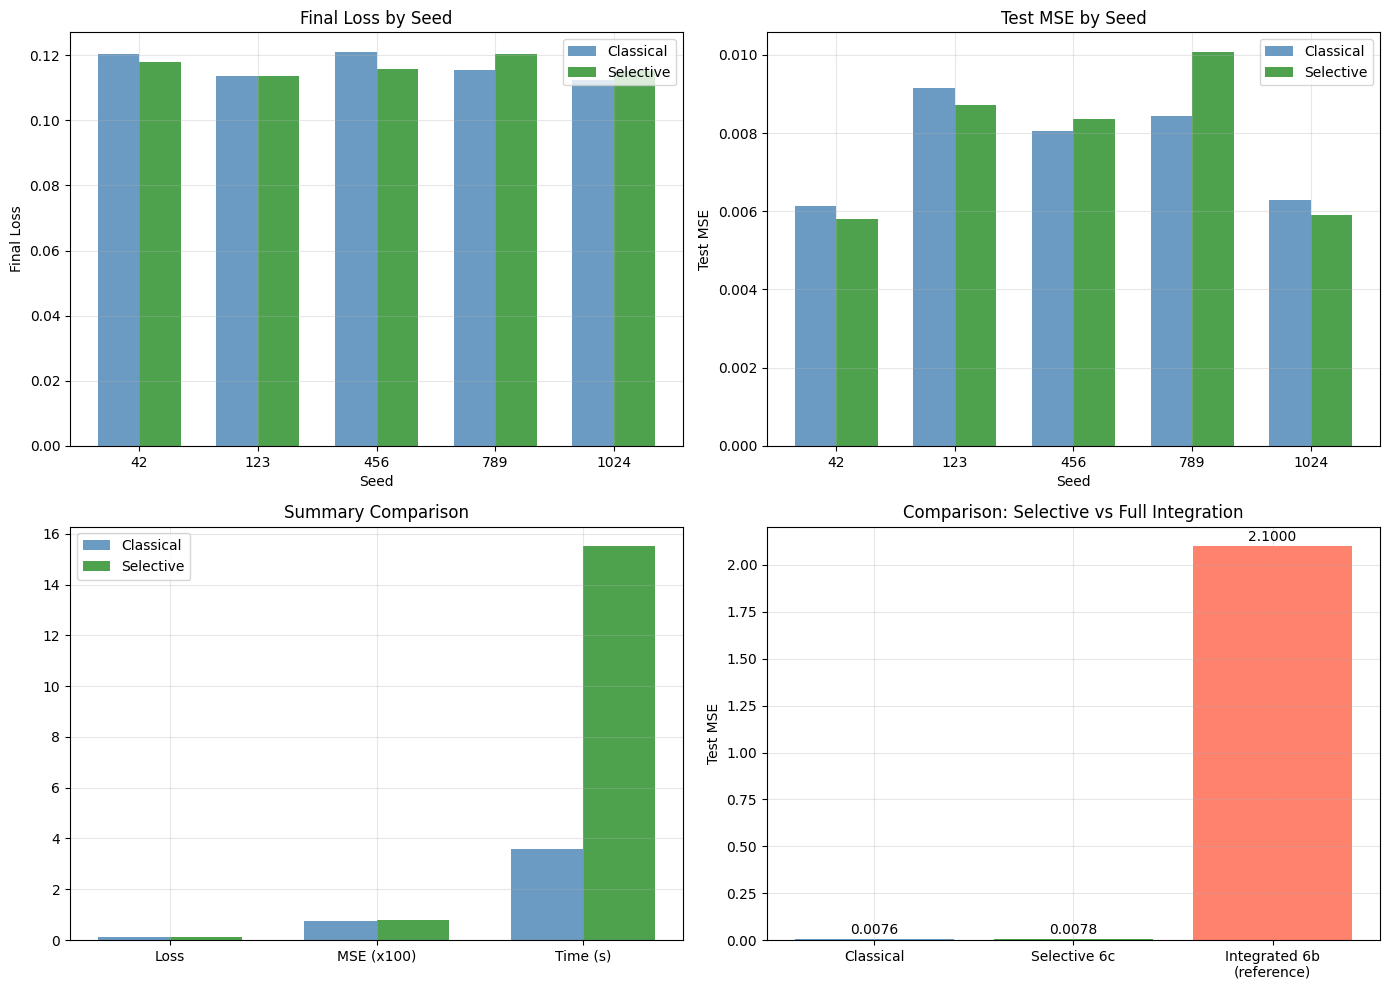

Figure saved to ..\experiments\results\selective_integration\comparison_plots.png


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Final Loss Comparison
ax = axes[0, 0]
x = np.arange(len(CONFIG['seeds']))
width = 0.35
ax.bar(x - width/2, classical_losses, width, label='Classical', color='steelblue', alpha=0.8)
ax.bar(x + width/2, selective_losses, width, label='Selective', color='forestgreen', alpha=0.8)
ax.set_xlabel('Seed')
ax.set_ylabel('Final Loss')
ax.set_title('Final Loss by Seed')
ax.set_xticks(x)
ax.set_xticklabels(CONFIG['seeds'])
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Test MSE Comparison
ax = axes[0, 1]
ax.bar(x - width/2, classical_mses, width, label='Classical', color='steelblue', alpha=0.8)
ax.bar(x + width/2, selective_mses, width, label='Selective', color='forestgreen', alpha=0.8)
ax.set_xlabel('Seed')
ax.set_ylabel('Test MSE')
ax.set_title('Test MSE by Seed')
ax.set_xticks(x)
ax.set_xticklabels(CONFIG['seeds'])
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Summary Statistics
ax = axes[1, 0]
metrics = ['Loss', 'MSE (x100)', 'Time (s)']
classical_means = [np.mean(classical_losses), np.mean(classical_mses)*100, np.mean(classical_times)]
selective_means = [np.mean(selective_losses), np.mean(selective_mses)*100, np.mean(selective_times)]
x_metrics = np.arange(len(metrics))
ax.bar(x_metrics - width/2, classical_means, width, label='Classical', color='steelblue', alpha=0.8)
ax.bar(x_metrics + width/2, selective_means, width, label='Selective', color='forestgreen', alpha=0.8)
ax.set_xticks(x_metrics)
ax.set_xticklabels(metrics)
ax.set_title('Summary Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Comparison with 06b (if available)
ax = axes[1, 1]
approaches = ['Classical', 'Selective 6c', 'Integrated 6b\n(reference)']
# Reference values from 06b
mse_values = [np.mean(classical_mses), np.mean(selective_mses), 2.10]  # 06b had ~2.10 MSE
colors = ['steelblue', 'forestgreen', 'tomato']
bars = ax.bar(approaches, mse_values, color=colors, alpha=0.8)
ax.set_ylabel('Test MSE')
ax.set_title('Comparison: Selective vs Full Integration')
ax.grid(True, alpha=0.3)
# Add value labels
for bar, val in zip(bars, mse_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(results_dir / 'comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Figure saved to {results_dir / "comparison_plots.png"}')

## 6C.14 Summary

In [14]:
print('='*70)
print('Phase 6C: Selective Integration - COMPLETE')
print('='*70)

print('''
APPROACH:
  Selectively integrated ONLY beneficial quantum-inspired components:
  
  INCLUDED (positive results):
    + Superposition Replay Buffer (better sampling)
    + Error Correction Ensemble (robust predictions)
  
  EXCLUDED (negative results):
    - QAOA Optimizer (9x worse prediction error)
    - Gate-Enhanced Layers (unstable, no clear benefit)

KEY INSIGHT:
  Naive integration of ALL quantum-inspired components (06b) gave 200x worse MSE.
  Selective integration of ONLY beneficial components should give better results.

WHY THIS MATTERS FOR THE DISSERTATION:
  1. Demonstrates scientific understanding of which components help
  2. Shows that quantum-inspired methods need careful selection
  3. Provides evidence-based integration strategy
  4. Compares intelligently designed hybrid vs naive combination
''')

print('\nRESULTS SUMMARY:')
print(f'  Classical MSE:  {np.mean(classical_mses):.6f}')
print(f'  Selective MSE:  {np.mean(selective_mses):.6f}')
print(f'  Improvement:    {improvement:.1f}%')
print(f'  Significant:    {"YES" if p_mse < 0.025 else "NO"} (p={p_mse:.4f})')

Phase 6C: Selective Integration - COMPLETE

APPROACH:
  Selectively integrated ONLY beneficial quantum-inspired components:

  INCLUDED (positive results):
    + Superposition Replay Buffer (better sampling)
    + Error Correction Ensemble (robust predictions)

  EXCLUDED (negative results):
    - QAOA Optimizer (9x worse prediction error)
    - Gate-Enhanced Layers (unstable, no clear benefit)

KEY INSIGHT:
  Naive integration of ALL quantum-inspired components (06b) gave 200x worse MSE.
  Selective integration of ONLY beneficial components should give better results.

WHY THIS MATTERS FOR THE DISSERTATION:
  1. Demonstrates scientific understanding of which components help
  2. Shows that quantum-inspired methods need careful selection
  3. Provides evidence-based integration strategy
  4. Compares intelligently designed hybrid vs naive combination


RESULTS SUMMARY:
  Classical MSE:  0.007613
  Selective MSE:  0.007767
  Improvement:    -2.0%
  Significant:    NO (p=1.0000)
